In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install the necessary libraries

In [ ]:
!pip install seaborn

In [ ]:
!pip install tensorflow

# Extract the dataset zip file

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Crop_Disease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Import the Libraries

In [ ]:
import os
import numpy as np
from numpy import unique, argmax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Convolution2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

## Loading the dataset


In [ ]:
train_path = r'/content/Crop_Disease/train'
test_path = r'/content/Crop_Disease/test'
val_path = r'/content/Crop_Disease/val'

#### Display the Crop Disease Image with Class Label

Rice___Hispa


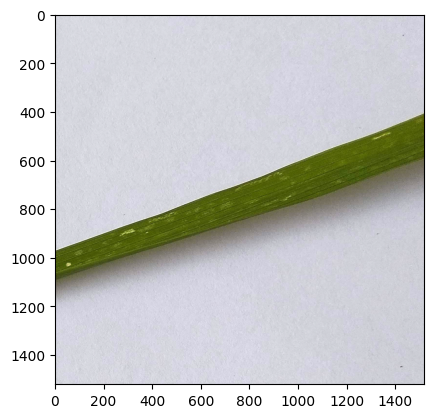

Wheat___Healthy


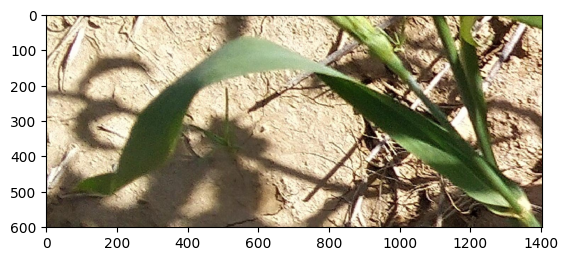

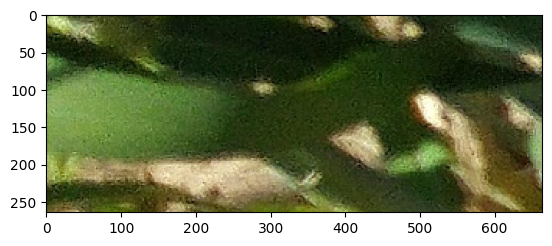

Wheat___Brown_Rust


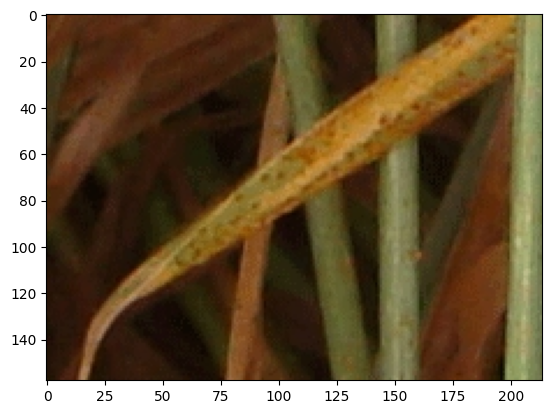

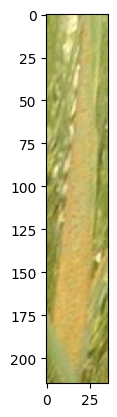

Corn___Gray_Leaf_Spot


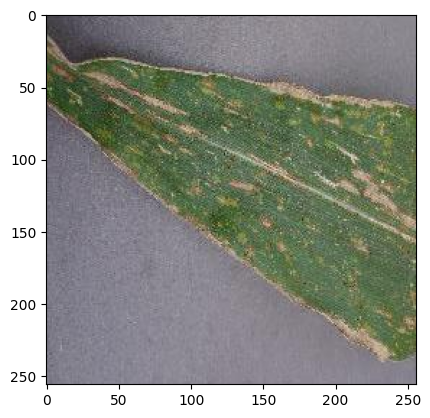

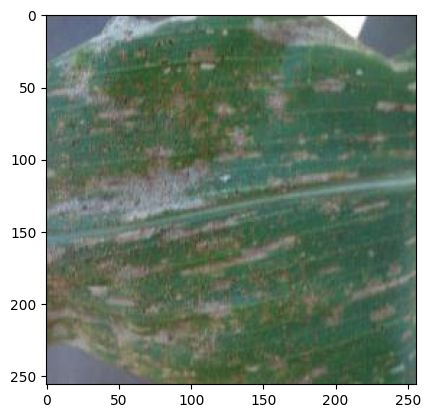

Potato___Healthy


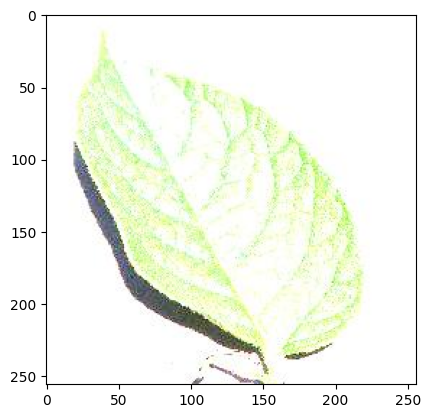

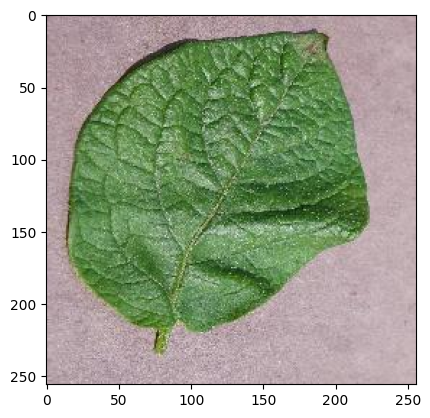

Potato___Early_Blight


Corn___Healthy


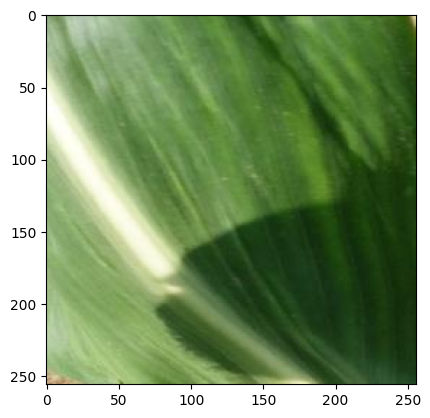

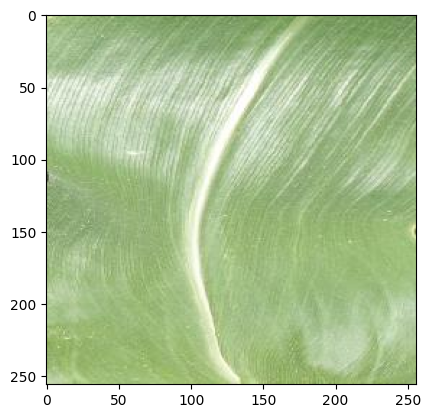

Potato___Late_Blight


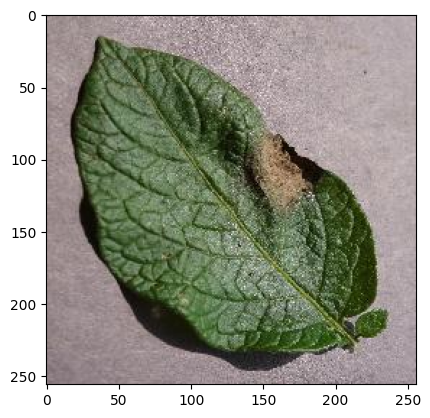

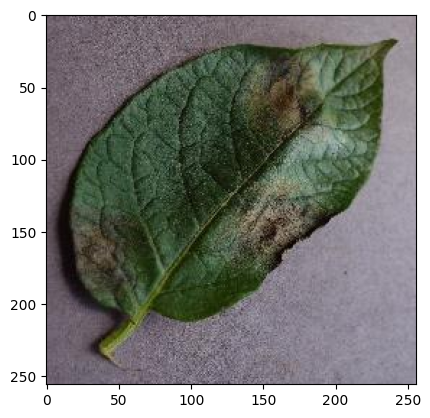

Corn___Leaf_Blight


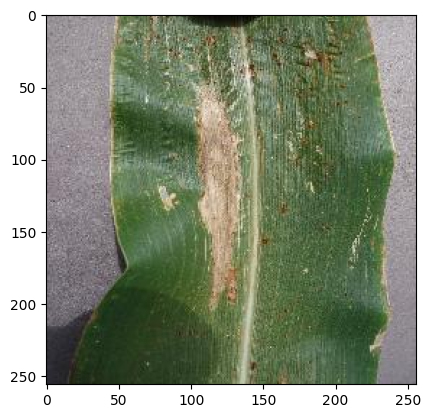

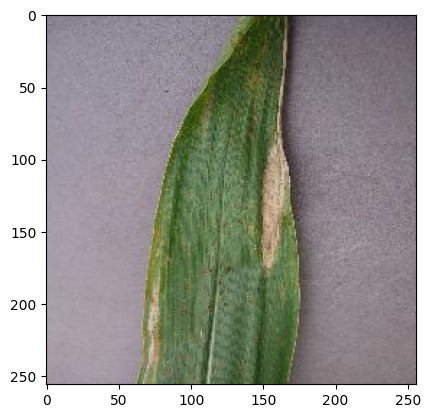

Rice___Brown_Spot


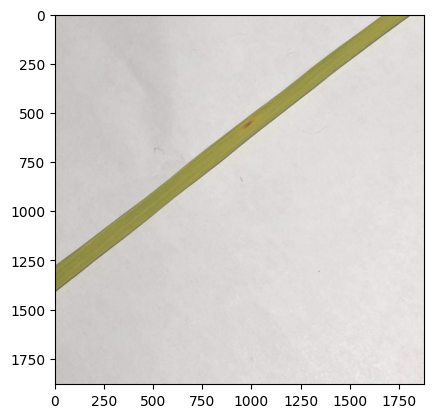

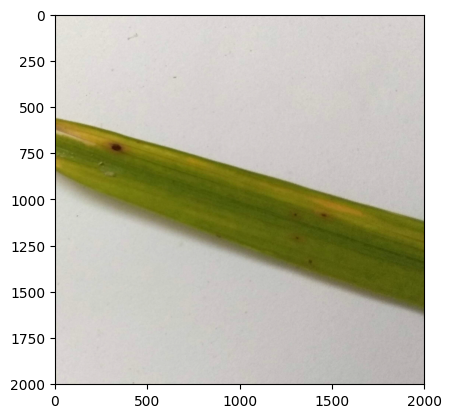

Rice___Healthy


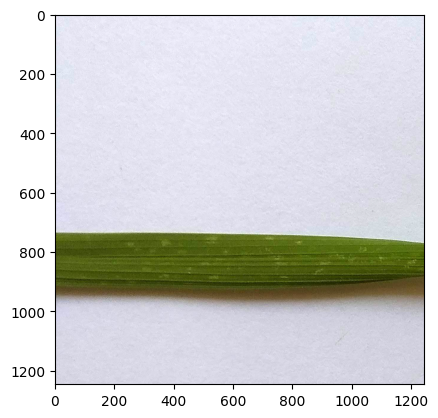

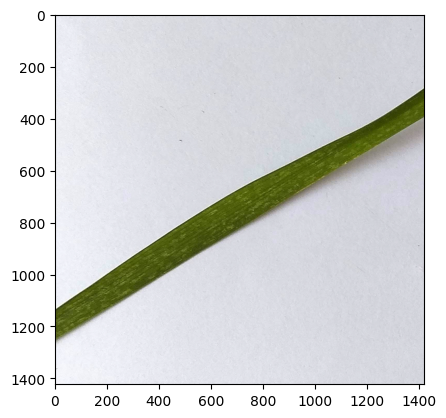

Corn___Common_Rust


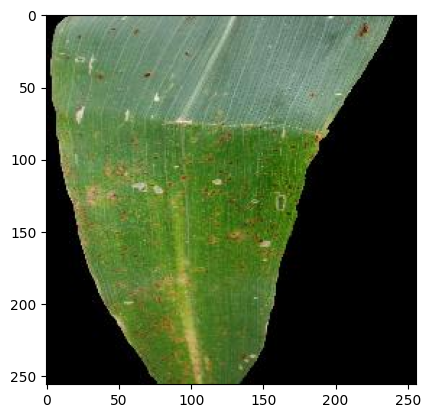

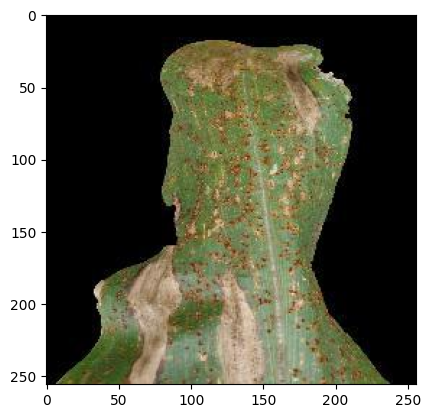

Rice___Leaf_Blast


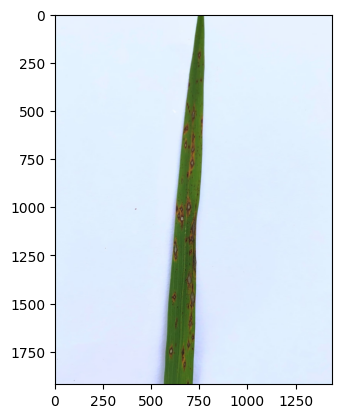

Wheat___Yellow_Rust


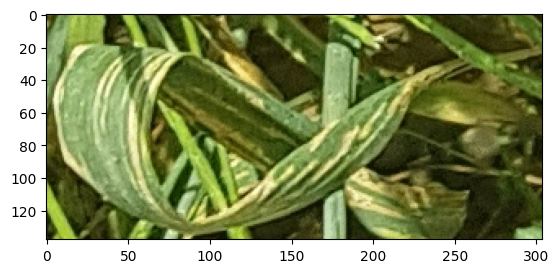

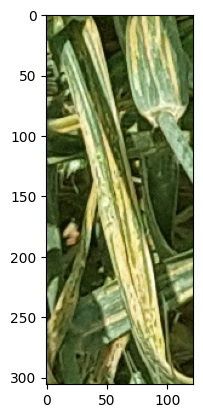

In [ ]:
# covert the image to pixel
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder

    print(folder)
    for i in range(2):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path)
        imgplot = plt.imshow(img)
        plt.show()

## Data Preprocessing

In [ ]:
# data pre-processing and augmentation of training image data
train_img_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

# pre-processing transformations on dataset of testing image data
test_img_datagen = ImageDataGenerator(rescale=1./255)

# generating the training Data
training_set = train_img_datagen.flow_from_directory(
        train_path,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')


# generating the testing image data
test_set = test_img_datagen.flow_from_directory(
        test_path,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

# Generating the testing image data
valid_set = test_img_datagen.flow_from_directory(
        val_path,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

Found 20637 images belonging to 14 classes.
Found 2962 images belonging to 14 classes.
Found 5891 images belonging to 14 classes.


In [ ]:
# printing class labels for each image
training_set.class_indices

{'Corn___Common_Rust': 0,
 'Corn___Gray_Leaf_Spot': 1,
 'Corn___Healthy': 2,
 'Corn___Leaf_Blight': 3,
 'Potato___Early_Blight': 4,
 'Potato___Healthy': 5,
 'Potato___Late_Blight': 6,
 'Rice___Brown_Spot': 7,
 'Rice___Healthy': 8,
 'Rice___Hispa': 9,
 'Rice___Leaf_Blast': 10,
 'Wheat___Brown_Rust': 11,
 'Wheat___Healthy': 12,
 'Wheat___Yellow_Rust': 13}

In [ ]:
# class_indices have the numeric tag for each images
train_classes = training_set.class_indices

# Storing the face and the numeric tag for future reference
result_map = {}
for crop_img_value, crop_img_name in zip(train_classes.values(), train_classes.keys()):
    result_map[crop_img_value] = crop_img_name

In [ ]:
print("Mapping of image and id", result_map)

Mapping of image and id {0: 'Corn___Common_Rust', 1: 'Corn___Gray_Leaf_Spot', 2: 'Corn___Healthy', 3: 'Corn___Leaf_Blight', 4: 'Potato___Early_Blight', 5: 'Potato___Healthy', 6: 'Potato___Late_Blight', 7: 'Rice___Brown_Spot', 8: 'Rice___Healthy', 9: 'Rice___Hispa', 10: 'Rice___Leaf_Blast', 11: 'Wheat___Brown_Rust', 12: 'Wheat___Healthy', 13: 'Wheat___Yellow_Rust'}


In [ ]:
# the number of neurons for the output layer is equal to the number of images
output_neurons = len(result_map)
print('\n The number of output neurons: ', output_neurons)


 The number of output neurons:  14


## Building the CNN model

In [ ]:
# Initializing the CNN
classifier = Sequential()

# STEP--1 Convolution
classifier.add(Convolution2D(32, kernel_size=(3, 3), strides=(1, 1), input_shape=(128,128,3), activation='relu'))

# STEP--2 MAX Pooling
classifier.add(MaxPool2D(pool_size=(2,2)))
# ADDITIONAL LAYER of CONVOLUTION for better accuracy
classifier.add(Convolution2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))

# STEP--3 FLattening
classifier.add(Flatten())

# STEP--4 Fully Connected Neural Network
classifier.add(Dense(256, activation='relu'))
classifier.add(Dense(output_neurons, activation='softmax'))

# Compiling the CNN
classifier.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=["accuracy"])

In [ ]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 256)               1

## Fitting the model

In [ ]:
import time
# measuring the time taken by the model to train
start_time = time.time()
# the model training
model_history=classifier.fit_generator(
                                        training_set,
                                        steps_per_epoch=len(training_set),
                                        epochs=20,
                                        validation_data=valid_set,
                                        validation_steps=len(valid_set),
                                        verbose=1)

end_time = time.time()
print(" Total Time Taken: ", round((end_time-start_time)/60), 'Minutes')

<ipython-input-17-2d551c4b925c>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history=classifier.fit_generator(


Epoch 1/20
645/645 [==============================] - 954s 1s/step - loss: 0.4861 - accuracy: 0.8219 - val_loss: 0.4956 - val_accuracy: 0.8177
Epoch 2/20
645/645 [==============================] - 890s 1s/step - loss: 0.2889 - accuracy: 0.8912 - val_loss: 0.2820 - val_accuracy: 0.8965
Epoch 3/20
645/645 [==============================] - 939s 1s/step - loss: 0.2369 - accuracy: 0.9101 - val_loss: 0.5034 - val_accuracy: 0.8250
Epoch 4/20
645/645 [==============================] - 866s 1s/step - loss: 0.2100 - accuracy: 0.9196 - val_loss: 0.2073 - val_accuracy: 0.9234
Epoch 5/20
645/645 [==============================] - 863s 1s/step - loss: 0.1892 - accuracy: 0.9268 - val_loss: 0.1983 - val_accuracy: 0.9321
Epoch 6/20
645/645 [==============================] - 868s 1s/step - loss: 0.1766 - accuracy: 0.9335 - val_loss: 0.2291 - val_accuracy: 0.9151
Epoch 7/20
645/645 [==============================] - 858s 1s/step - loss: 0.1590 - accuracy: 0.9393 - val_loss: 0.2365 - val_accuracy: 0.9194

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy  = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

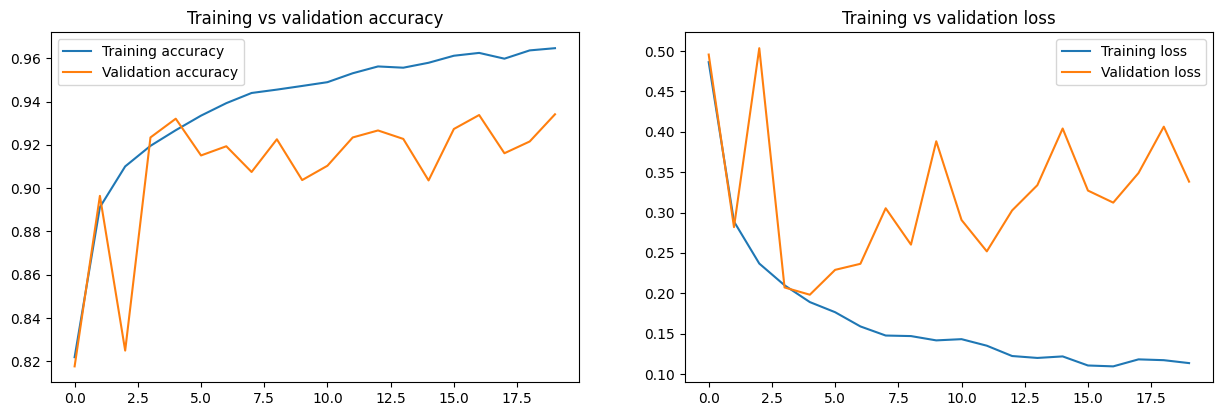

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

## Evaluate the model

In [ ]:
test_loss, test_acc = classifier.evaluate(test_set, steps=len(test_set))
print('\nTest accuracy:', test_acc)

93/93 [==============================] - 50s 535ms/step - loss: 0.3308 - accuracy: 0.9318

Test accuracy: 0.9318028092384338
